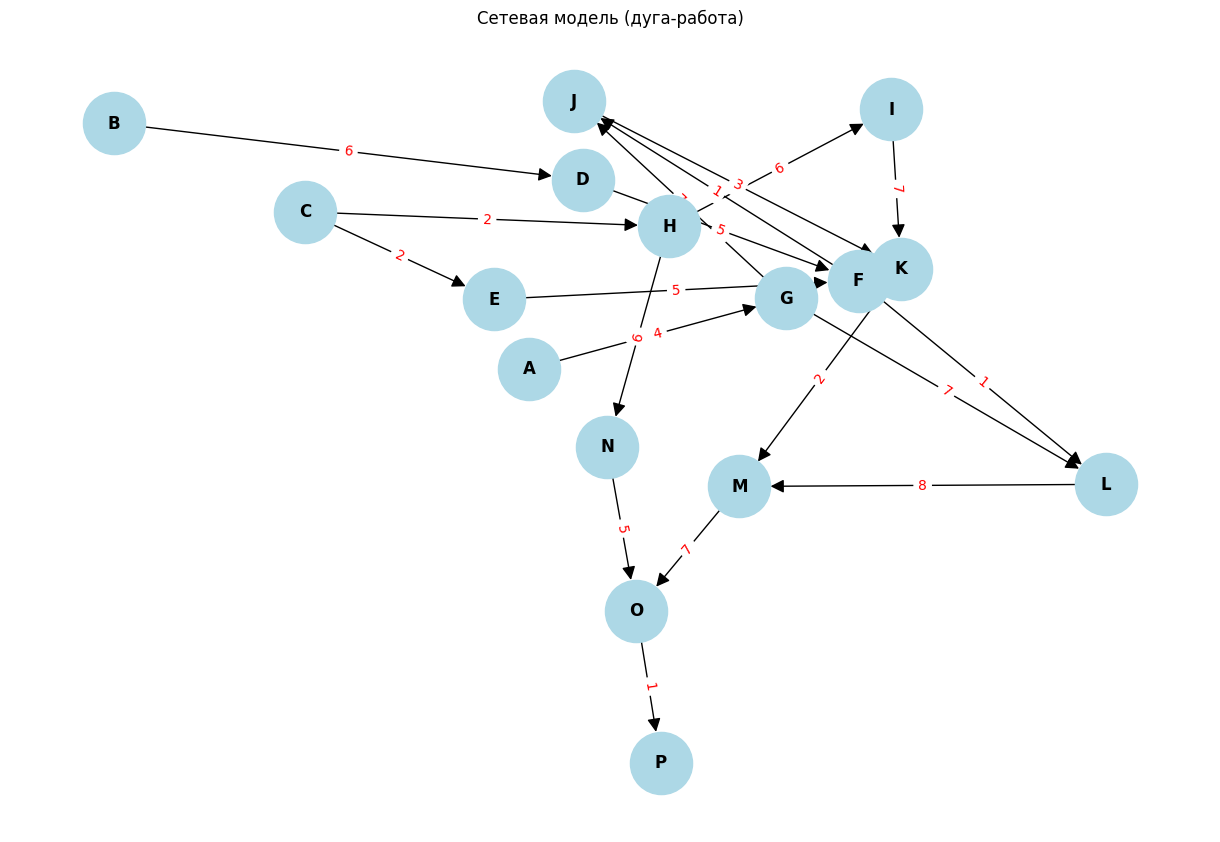

In [5]:
# Импорт библиотек
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime, timedelta

# Данные из таблицы
data = {
    'Работа': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P'],
    'Последователи': ['G', 'D', 'E,H', 'F', 'F', 'J,L', 'J,L', 'I,N', 'K', 'K', 'M', 'M', 'O', 'O', 'P', ''],
    'Предшественники': ['', '', '', 'B', 'C', 'D,E', 'A', 'C', 'H', 'F,G', 'I,J', 'F,G', 'K,L', 'H', 'M,N', 'O'],
    'Продолжительность': [4, 6, 2, 5, 5, 1, 7, 6, 7, 3, 2, 8, 7, 5, 1, 8]
}

df = pd.DataFrame(data)

# Преобразуем последователей в список
df['Последователи'] = df['Последователи'].apply(lambda x: x.split(',') if x else [])

# Создаем граф
G = nx.DiGraph()

# Добавляем узлы и ребра
for _, row in df.iterrows():
    work = row['Работа']
    duration = row['Продолжительность']
    G.add_node(work, duration=duration)
    for follower in row['Последователи']:
        if follower:
            G.add_edge(work, follower)

# Визуализация графа
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightblue', 
        font_size=12, font_weight='bold', arrows=True, arrowsize=20)
edge_labels = {(u, v): f'{G.nodes[u]["duration"]}' for u, v in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
plt.title('Сетевая модель (дуга-работа)')
plt.show()


In [3]:

# Построение диаграммы Ганта
# Рассчитаем ранние начала и окончания
def calculate_early_times(graph):
    early_start = {node: 0 for node in graph.nodes()}
    early_finish = {}
    for node in nx.topological_sort(graph):
        max_prev_finish = 0
        for pred in graph.predecessors(node):
            max_prev_finish = max(max_prev_finish, early_finish[pred])
        early_start[node] = max_prev_finish
        early_finish[node] = early_start[node] + graph.nodes[node]['duration']
    return early_start, early_finish

early_start, early_finish = calculate_early_times(G)

# Создаем DataFrame для Ганта
gantt_data = []
for work in df['Работа']:
    gantt_data.append({
        'Task': work,
        'Start': early_start[work],
        'Finish': early_finish[work],
        'Duration': early_finish[work] - early_start[work]
    })

gantt_df = pd.DataFrame(gantt_data)

# Визуализация диаграммы Ганта
fig = px.timeline(gantt_df, x_start='Start', x_end='Finish', y='Task', title='Диаграмма Ганта')
fig.update_yaxes(categoryorder='total ascending')
fig.show()


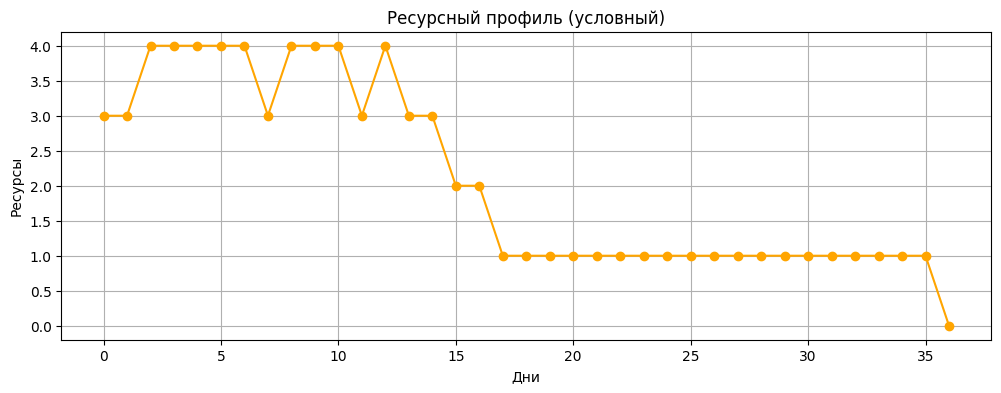

In [4]:

# Ресурсный профиль (условный: каждая работа требует 1 ресурс в день)
days = range(0, max(early_finish.values()) + 1)
resource_usage = [0] * (max(days) + 1)

for work in df['Работа']:
    for day in range(early_start[work], early_finish[work]):
        resource_usage[day] += 1

plt.figure(figsize=(12, 4))
plt.plot(days[:len(resource_usage)], resource_usage, marker='o', linestyle='-', color='orange')
plt.xlabel('Дни')
plt.ylabel('Ресурсы')
plt.title('Ресурсный профиль (условный)')
plt.grid(True)
plt.show()

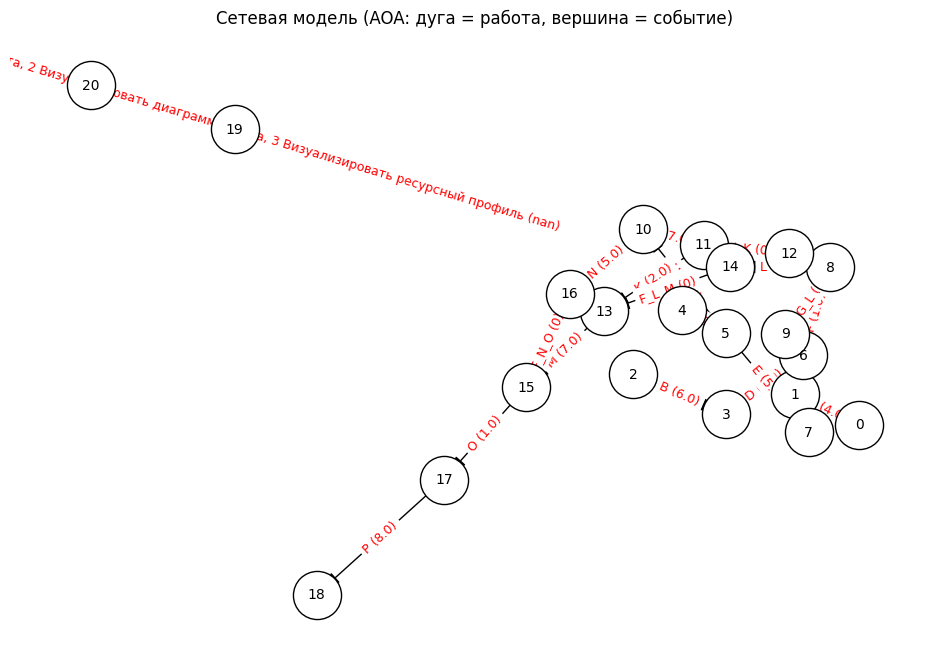

TypeError: 'float' object cannot be interpreted as an integer

In [14]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import plotly.express as px

# ========================
# Загружаем данные из Excel
# ========================
path = "Практика1.xlsx"
df = pd.read_excel(path)

# Преобразуем к правильному виду
df['Предшественники'] = df['Предшественники'].fillna('').astype(str)
df['Последователи'] = df['Последователи'].fillna('').astype(str)
df['Предшественники'] = df['Предшественники'].apply(lambda x: x.split(',') if x else [])
df['Последователи'] = df['Последователи'].apply(lambda x: x.split(',') if x else [])

# ========================
# Строим AOA (Activity on Arrow)
# ========================
G = nx.DiGraph()
event_counter = 0
work_to_events = {}
end_events = {}

for _, row in df.iterrows():
    work = row['Работа']
    preds = [p.strip() for p in row['Предшественники'] if p.strip()]
    duration = row['Продолжительность']

    if not preds:
        # стартовая работа → новое начальное событие
        start_event = event_counter
        event_counter += 1
    else:
        # начало = конец первого предшественника
        start_event = end_events[preds[0]]
        # если несколько предшественников → фиктивные работы
        for p in preds[1:]:
            fake_start = end_events[p]
            fake_end = start_event
            G.add_edge(fake_start, fake_end, work=f"F_{p}_{work}", duration=0)

    # новое конечное событие
    end_event = event_counter
    event_counter += 1

    # добавляем реальную работу
    G.add_edge(start_event, end_event, work=work, duration=duration)
    work_to_events[work] = (start_event, end_event)
    end_events[work] = end_event

# ========================
# Визуализация AOA
# ========================
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)

nx.draw_networkx_nodes(G, pos, node_size=1200, node_color="white", edgecolors="black")
nx.draw_networkx_labels(G, pos, labels={n: str(n) for n in G.nodes()}, font_size=10)

edge_labels = {(u, v): f"{d['work']} ({d['duration']})" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edges(G, pos, arrows=True, arrowsize=20, edge_color="black")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red", font_size=9)

plt.title("Сетевая модель (AOA: дуга = работа, вершина = событие)")
plt.axis("off")
plt.show()

# ========================
# Диаграмма Ганта (классическая)
# ========================
def calculate_early_times(graph):
    early_start = {node: 0 for node in graph.nodes()}
    early_finish = {}
    for node in nx.topological_sort(graph):
        max_prev_finish = 0
        for pred in graph.predecessors(node):
            max_prev_finish = max(max_prev_finish, early_finish[pred])
        early_start[node] = max_prev_finish
        early_finish[node] = early_start[node] + graph.nodes[node]['duration']
    return early_start, early_finish

# Для Ганта используем модель "работа = блок"
G_blocks = nx.DiGraph()
for _, row in df.iterrows():
    work = row['Работа']
    duration = row['Продолжительность']
    G_blocks.add_node(work, duration=duration)
    for pred in row['Предшественники']:
        if pred:
            G_blocks.add_edge(pred, work)

early_start, early_finish = calculate_early_times(G_blocks)

gantt_data = []
for work in df['Работа']:
    gantt_data.append({
        'Task': work,
        'Start': early_start[work],
        'Finish': early_finish[work],
        'Duration': early_finish[work] - early_start[work]
    })

gantt_df = pd.DataFrame(gantt_data)

fig = px.timeline(gantt_df, x_start='Start', x_end='Finish', y='Task', title='Диаграмма Ганта')
fig.update_yaxes(categoryorder='total ascending')
fig.show()

# ========================
# Ресурсный профиль (1 работа = 1 ресурс)
# ========================
days = range(0, max(early_finish.values()) + 1)
resource_usage = [0] * (max(days) + 1)

for work in df['Работа']:
    for day in range(early_start[work], early_finish[work]):
        resource_usage[day] += 1

plt.figure(figsize=(12, 4))
plt.plot(days[:len(resource_usage)], resource_usage, marker='o', linestyle='-', color='orange')
plt.xlabel('Дни')
plt.ylabel('Ресурсы')
plt.title('Ресурсный профиль (условный)')
plt.grid(True)
plt.show()
